## Imports & Map Dataset

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
import glob
import sys
import cmocean
import netCDF4
import cartopy.mpl.gridliner as gridliner
from scipy.interpolate import griddata
import glidertools as gt



#import h5netcdf


# if sys.platform == 'darwin':
#     os.chdir(r'/Users/brianverwey/Library/CloudStorage/GoogleDrive-brian.j.vw@gmail.com/My Drive/Oregon State/Glider/coding')
# elif sys.platform == 'win32': 
#     os.chdir(r'G:\My Drive\Oregon State\Glider\coding') ### Change based on location / computer being used



access_pr_file = 'C:/Users/marqjace/OneDrive - Oregon State University/Desktop/Python/northern_california_36_msl_2005.nc'

ds = xr.open_dataset(access_pr_file)


In [2]:
ds

<xarray.Dataset> Size: 6MB
Dimensions:  (lat: 1400, lon: 1000)
Coordinates:
  * lat      (lat) float64 11kB 39.01 39.02 39.02 39.03 ... 52.98 52.98 53.0
  * lon      (lon) float64 8kB -132.0 -132.0 -132.0 ... -122.0 -122.0 -122.0
Data variables:
    Band1    (lat, lon) float32 6MB ...
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 2.1.0, released 2016/04/25
    title:        Northern California 36 sec Coastal Digital Elevation Model
    NCO:          4.6.8
    history:      Wed Jan 31 18:00:32 2018: ncatted -O -a history,global,d,c,...

In [3]:
ds.data_vars

Data variables:
    Band1    (lat, lon) float32 6MB ...

## Plot whatever is in here

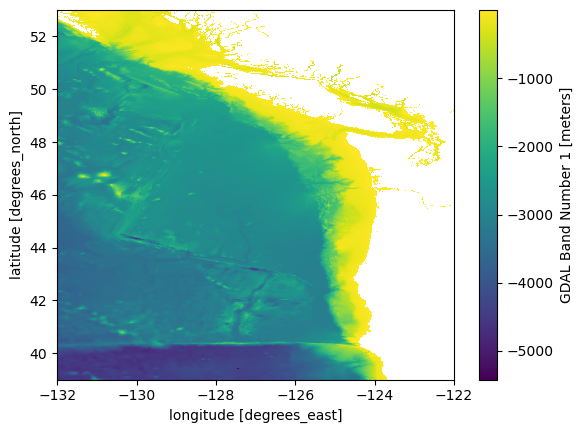

In [4]:
ds.Band1.plot()

## Contour plot of bathymetery

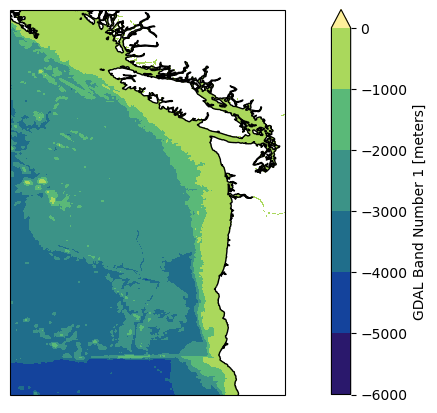

In [5]:
# clim.sel(season='JJA') is based off of clim - (season) object 'DJF' 'JJA' 'MAM' 'SON'
fig = plt.figure(figsize=[12,5])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
ds.Band1.plot.contourf(ax=ax,
                   #levels=np.arange(0, 13.5, 3.0),
                   extend='max',
                   transform=ccrs.PlateCarree(),
                   #cbar_kwargs={'label': ds.units},
                   cmap=cmocean.cm.haline)
ax.coastlines()
plt.show()

## Glider Track

In [6]:
# Open 
filenames = 'C:/Users/marqjace/TH_line/deployments/apr_2024/transect2/p686*.nc'

gt.load.seaglider_show_variables(filenames)

names = [
    'ctd_depth',
    'ctd_time',
    'ctd_pressure',
    'salinity',
    'temperature',
]

ds_dict = gt.load.seaglider_basestation_netCDFs(
    filenames, names,
    return_merged=True,
    keep_global_attrs=False
)

print(ds_dict.keys())

sg_data_point = ds_dict['sg_data_point']

dat = sg_data_point.rename({
    'salinity': 'salt_raw',
    'temperature': 'temp_raw',
    'ctd_pressure': 'pressure',
    'ctd_depth': 'depth',
    'ctd_time': 'time_raw',
})

print(dat)

# variable assignment for conveniant access
depth2 = dat.depth
dives2 = dat.dives
latitude2 = dat.latitude
longitude2 = dat.longitude
pres2 = dat.pressure
temp2 = dat.temp_raw
salt2 = dat.salt_raw


# name coordinates for quicker plotting
x = dat.longitude
y = dat.latitude


# Set up new grid (96 points longitude is every 5 km, 200 points depth is every 5 meters)


# number of grid points:

xn, yn = 112, 200


# grid window

xmin, xmax = -130.5, -123.5
ymin, ymax = 0, 1000


# Generate a regular grid to interpolate the data

xgrid = np.linspace(xmin, xmax, xn)
ygrid = np.linspace(ymin, ymax, yn)
Xgrid3, Ygrid3 = np.meshgrid(xgrid, ygrid)


# Interpolate using "linear" method

Z = griddata(points = (longitude2, depth2),
              values = temp2,
              xi = (Xgrid3, Ygrid3),
              method = 'linear')

information is based on file: C:/Users/marqjace/TH_line/deployments/apr_2024/transect2\p6860153.nc

DIMENSION: sg_data_point
{ctd_time, ctd_pressure, latitude, ctd_depth, longitude, salinity, temperature}


100%|██████████| 85/85 [00:00<00:00, 244.91it/s]



Cannot merge data - not enough time indexed DataFrames
Returning unmerged dataframes
dict_keys(['sg_data_point'])
<xarray.Dataset> Size: 10MB
Dimensions:        (sg_data_point: 145567)
Coordinates:
    ctd_time_dt64  (sg_data_point) datetime64[ns] 1MB 2024-05-03T21:50:44 ......
    latitude       (sg_data_point) float64 1MB 41.05 41.05 41.05 ... 41.06 41.06
    depth          (sg_data_point) float64 1MB 0.6148 0.6964 ... -0.005865
    longitude      (sg_data_point) float64 1MB -129.1 -129.1 ... -125.6 -125.6
Dimensions without coordinates: sg_data_point
Data variables:
    time_raw       (sg_data_point) float64 1MB 1.715e+09 1.715e+09 ... 1.717e+09
    pressure       (sg_data_point) float64 1MB 0.6204 0.7026 ... -0.005698
    salt_raw       (sg_data_point) float64 1MB nan nan nan nan ... nan nan nan
    temp_raw       (sg_data_point) float64 1MB 12.13 12.12 12.12 ... 12.54 12.54
    dives          (sg_data_point) float64 1MB 111.0 111.0 111.0 ... 195.5 195.5
Attributes:
    date_creat

## Maps

### Inshore Map

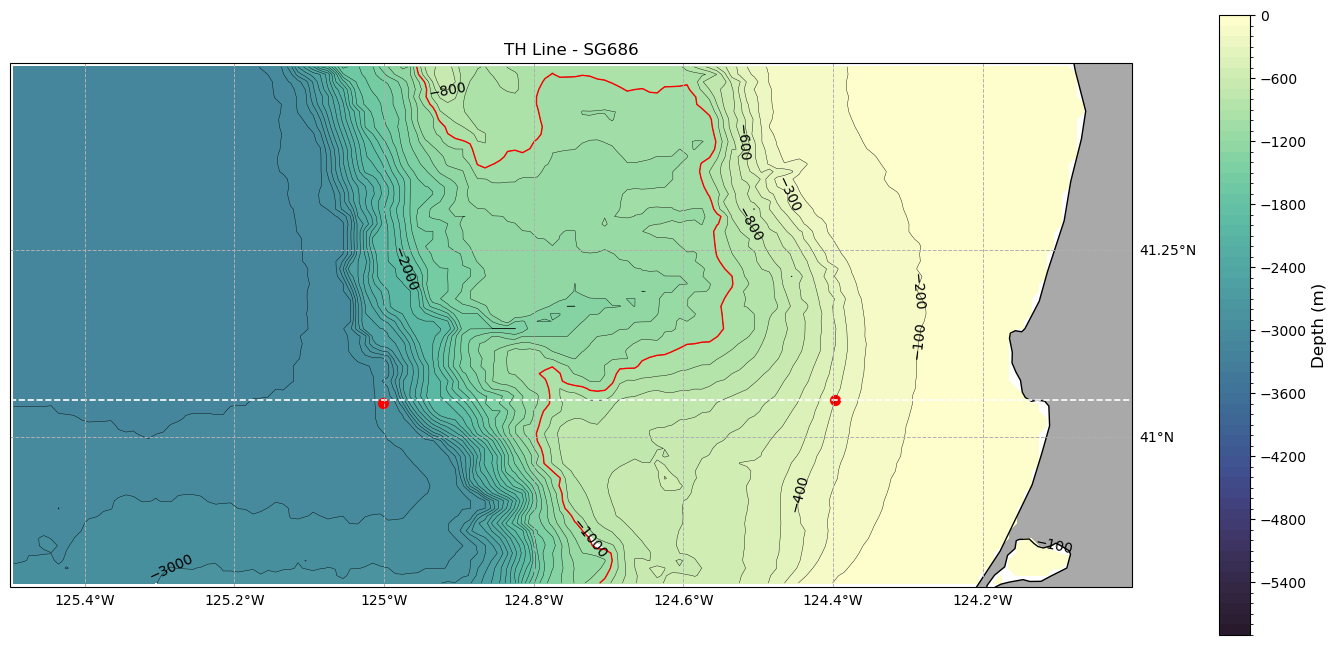

In [7]:
fig = plt.figure(figsize=[16,9])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))

# Change longitude 
longitude_west = -125.5
longitude_east = -124
latitude_south = 40.8
latitude_north = 41.5

# Clip the dataset to the specified extent using .sel()
ds = ds.sel(lon=slice(longitude_west, longitude_east), lat=slice(latitude_south, latitude_north))

# set the exent of the plot - this was used before I used the ds.sel method to clip the dataset
ax.set_extent([longitude_west, longitude_east, latitude_south, latitude_north])

# Create an array for levels (bathymetry depth bins)
array = np.arange(0, -6000, -100)
contours = [-5900, -5000, -4000, -3000, -2000, -1000, -800, -600, -400, -300, -200, -100]

# Add contourf plot of Band1 aka depth, colorbar, label
contourf = ds.Band1.plot.contourf(ax=ax,
                    levels = array,
                    transform=ccrs.PlateCarree(),
                    cmap=cmocean.cm.deep_r,
                    add_colorbar=False)

# Add a colorbar to the plot for the contourf plot only
cbar = plt.colorbar(contourf, ax=ax, orientation='vertical', fraction=0.025, pad=0.07)
cbar.set_label('Depth (m)', fontsize=12, loc = 'center')
ax.clabel(contourf, contours, inline=True, fontsize=10, colors='k')


# Add contour lines on top of the filled contour plot
contour = ds.Band1.plot.contour(ax=ax,
                                levels=array,  # or specify the levels as needed
                                colors='black',  # color of the contour lines
                                linewidths=0.3,# linewidth of the contour lines
                                linestyles='-',
                                transform=ccrs.PlateCarree())


# Add contour lines on top of the filled contour plot
contour = ds.Band1.plot.contour(ax=ax,
                                levels=[-1000],  # Only plot the contour for Band1 = 1000
                                colors=['red'],  # Change the color to red
                                linewidths=1,  # Adjust the linewidth as needed
                                linestyles='-',  # Use a dashed line style
                                transform=ccrs.PlateCarree())

# Plot the line at 41.05N from the coastline to the western extent
ax.plot([longitude_west, longitude_east], 
        [41.05, 41.05], 
        color='white', 
        linestyle='--',
        linewidth = 1.2,
        transform=ccrs.PlateCarree())

# Add the specific points to the map, eventually add all surface locations or just one...
ax.scatter(-124.396833, 41.05, color='red', s=50, transform=ccrs.PlateCarree())
ax.scatter(-125.001, 41.045667, color='red', s=50, transform=ccrs.PlateCarree())

# Add the glider track
ax.scatter(x, y, c='orange', s=1, transform=ccrs.PlateCarree())
ax.scatter(x[-1], y[-1], c='blue', s=5, transform=ccrs.PlateCarree())


# Add grid lines and labels
gl = ax.gridlines(draw_labels=False, 
                  linestyle='--', 
                  ylocs=np.arange(40.5, 42, 0.25), #lat_south, lat_north, spacing
                  linewidth = 0.7
                  ) 


# Add lat lon labels
gl.bottom_labels = True
gl.right_labels = True
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}


# Add border features
state_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(state_provinces, edgecolor = 'k')
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='darkgray')

ax.set_title('TH Line - SG686')


plt.show()

### Full TH Line Map

In [8]:
th_line_lon = [-124.4758, -124.9167, -125.3575, -125.805, -126.2458, -126.6867, -127.1275, -128, -129, -130]
th_line_lat = [41.0583, 41.0583, 41.0583, 41.0583, 41.0583, 41.0583, 41.0583, 41.0583, 41.0583, 41.0583]

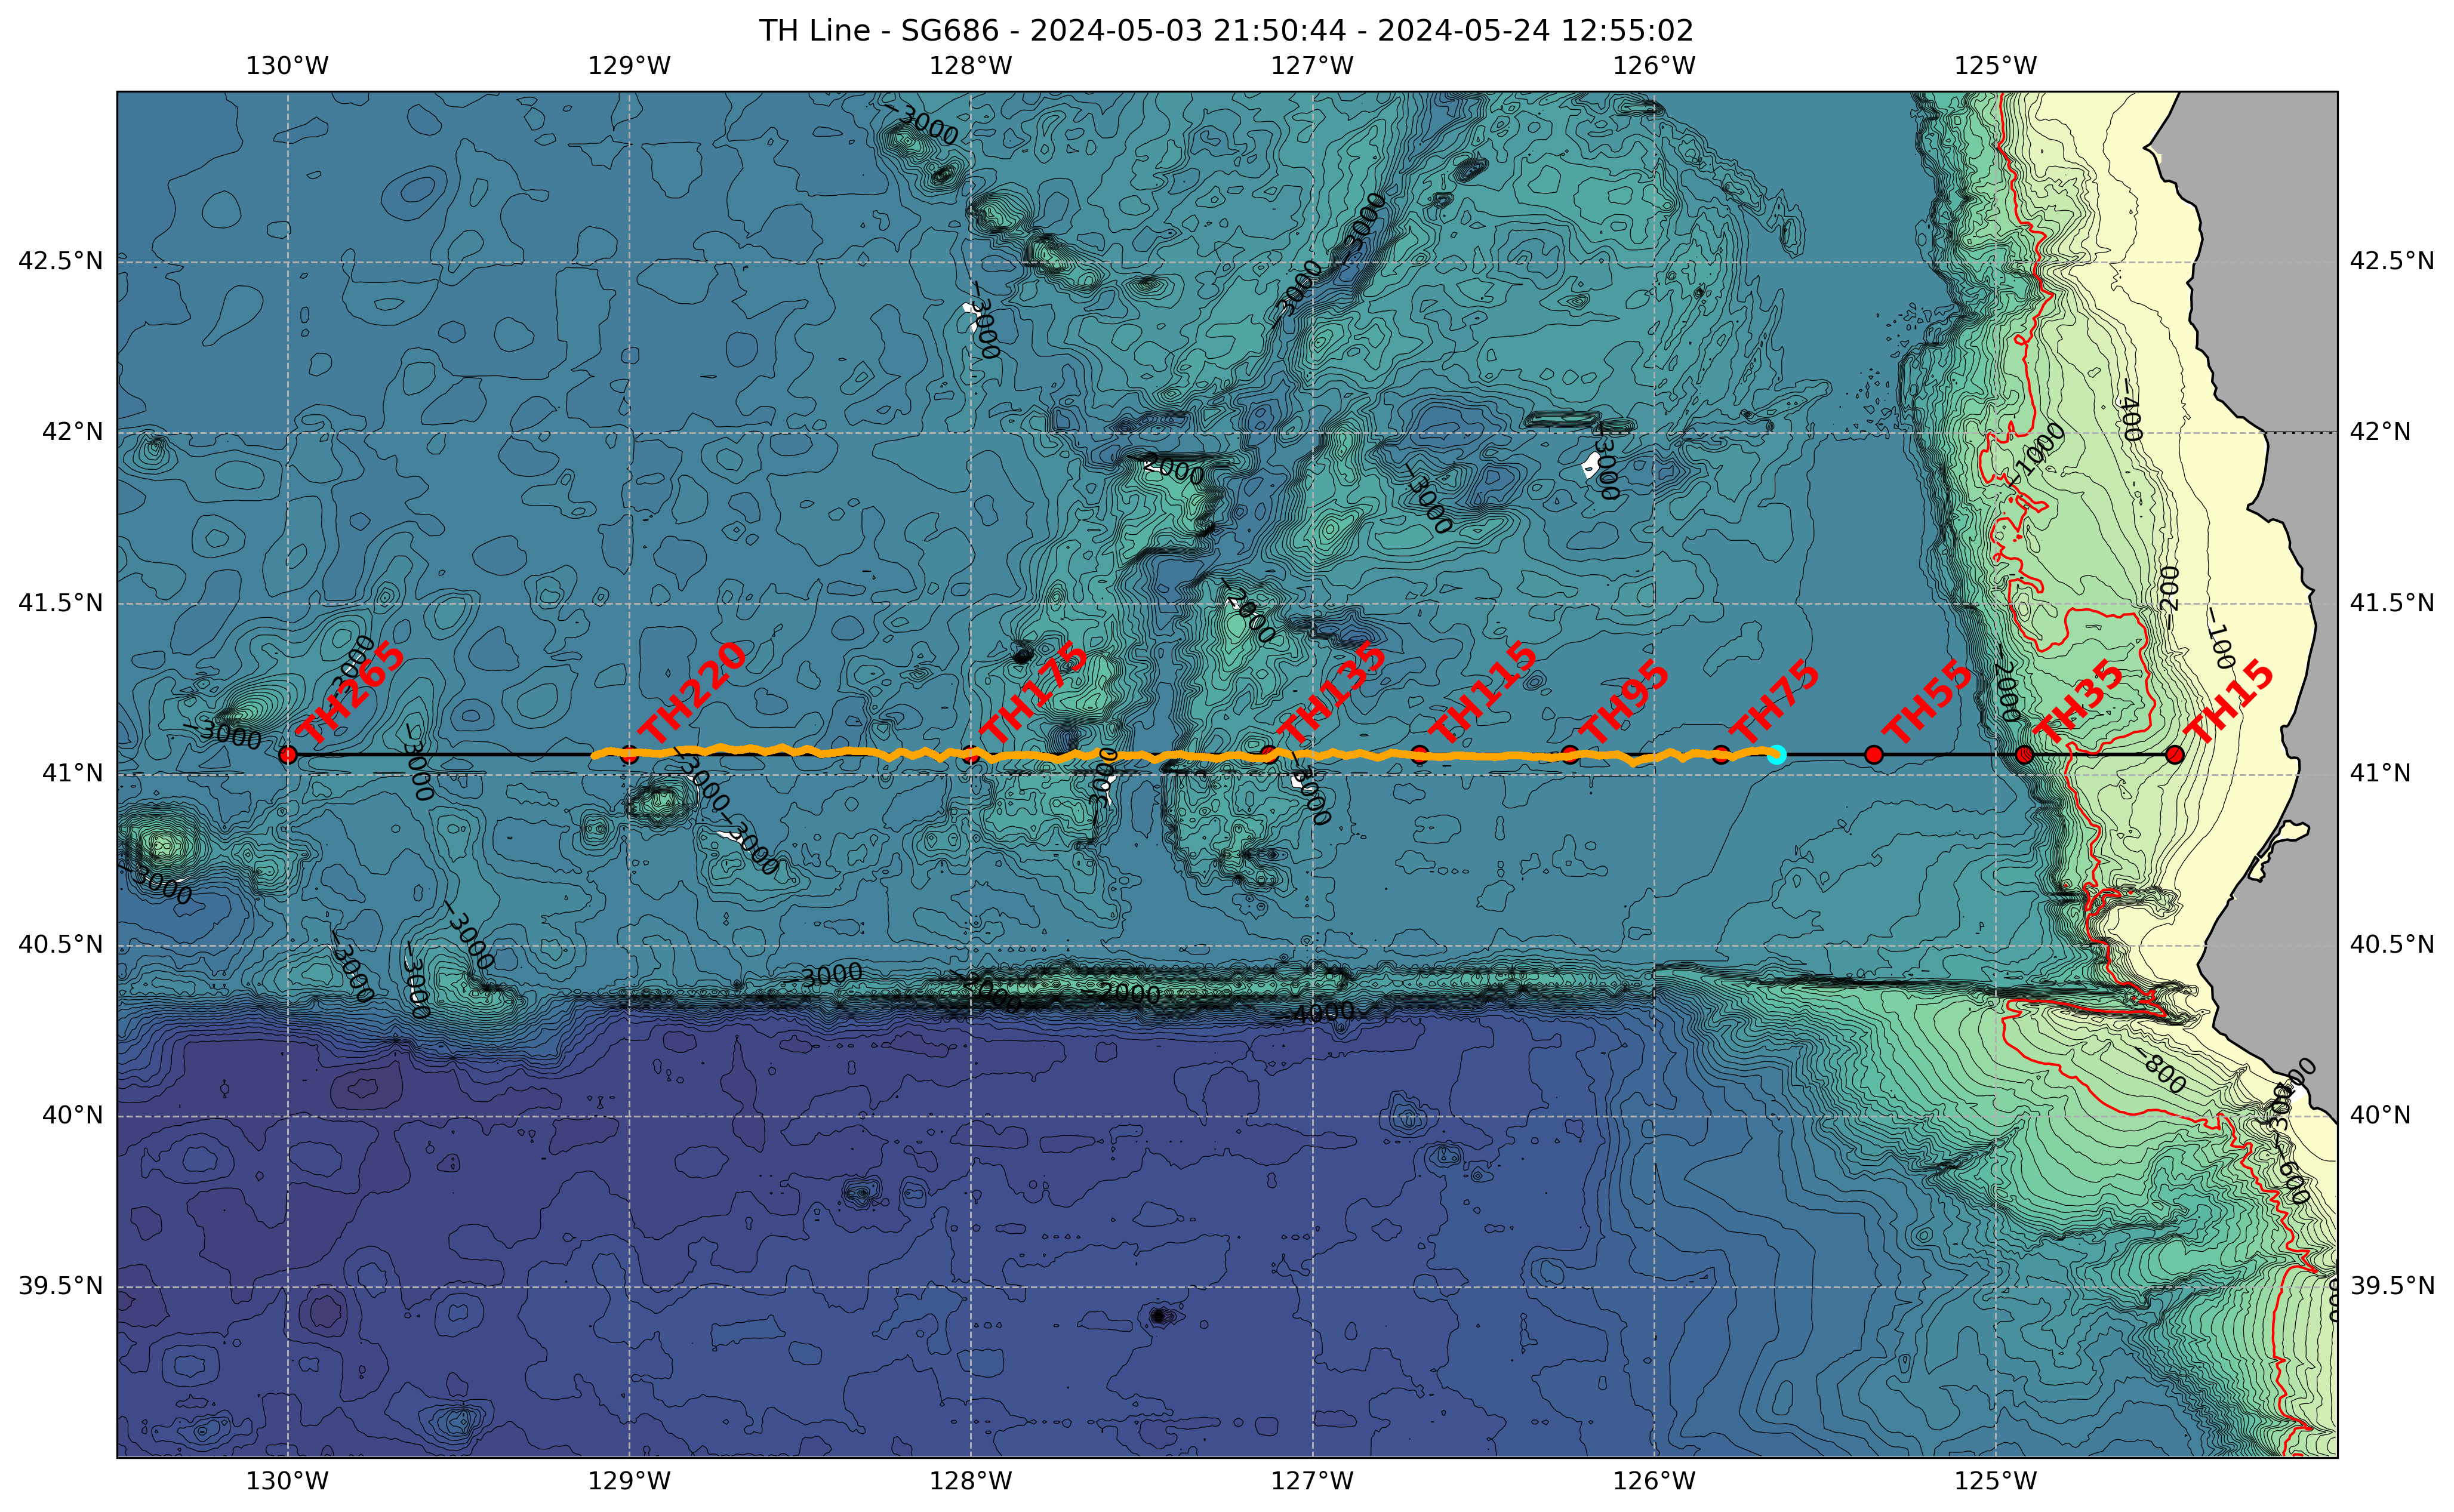

In [10]:
ds = xr.open_dataset(access_pr_file)

fig = plt.figure(figsize=[16,16], dpi=300)
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))

# Change longitude 
longitude_west = -130.5
longitude_east = -124
latitude_south = 39
latitude_north = 43

# Clip the dataset to the specified extent using .sel()
ds = ds.sel(lon=slice(longitude_west, longitude_east), lat=slice(latitude_south, latitude_north))

# set the exent of the plot - this was used before I used the ds.sel method to clip the dataset
ax.set_extent([longitude_west, longitude_east, latitude_south, latitude_north])

# set the time coverage start and end
time_start = dat.attrs['time_coverage_start']
time_end = dat.attrs['time_coverage_end']

# Create an array for levels (bathymetry depth bins)
array = np.arange(0, -6000,-100)
contours = [-5900, -5000, -4000, -3000, -2000, -1000, -800, -600, -400, -300, -200, -100]
# contours2 = [0, -100, -200, -300, -400, -600, -800, -1000, -2000, -3000, -4000, -5000, -6000]

# Add contourf plot of Band1 aka depth, colorbar, label
contourf = ds.Band1.plot.contourf(ax=ax,
                    levels = array,
                    transform=ccrs.PlateCarree(),
                    cmap=cmocean.cm.deep_r,
                    add_colorbar=False)

# # Add a colorbar to the plot for the contourf plot only
# cbar = plt.colorbar(contourf, ax=ax, orientation='vertical', fraction=0.025, pad=0.07)
# cbar.set_label('Depth (m)', fontsize=12, loc = 'center')
ax.clabel(contourf, contours, inline=True, fontsize=10, colors='k')


# Add contour lines on top of the filled contour plot
contour = ds.Band1.plot.contour(ax=ax,
                                levels=array,  # or specify the levels as needed
                                colors='black',  # color of the contour lines
                                linewidths=0.3,# linewidth of the contour lines
                                linestyles='-',
                                transform=ccrs.PlateCarree())


# Add contour lines on top of the filled contour plot
contour = ds.Band1.plot.contour(ax=ax,
                                levels=[-1000],  # Only plot the contour for Band1 = 1000
                                colors=['red'],  # Change the color to red
                                linewidths=1,  # Adjust the linewidth as needed
                                linestyles='-',  # Use a dashed line style
                                transform=ccrs.PlateCarree())

# # Plot the line at 41.05N from the coastline to the western extent
# ax.plot([longitude_west, longitude_east], 
#         [41.05, 41.05], 
#         color='white', 
#         linestyle='--',
#         linewidth = 1.2,
#         transform=ccrs.PlateCarree())

# Add the TH Line points to the map
ax.plot(th_line_lon, th_line_lat, marker='o', markersize=7, markerfacecolor='r', color='k', transform=ccrs.PlateCarree(), zorder=1)
ax.text(th_line_lon[0] + 0.02, th_line_lat[0] + 0.02, 'TH15', rotation=45, c='r', size=15, fontweight='bold', transform=ccrs.PlateCarree())
ax.text(th_line_lon[1] + 0.02, th_line_lat[1] + 0.02, 'TH35', rotation=45, c='r', size=15, fontweight='bold', transform=ccrs.PlateCarree())
ax.text(th_line_lon[2] + 0.02, th_line_lat[2] + 0.02, 'TH55', rotation=45, c='r', size=15, fontweight='bold', transform=ccrs.PlateCarree())
ax.text(th_line_lon[3] + 0.02, th_line_lat[3] + 0.02, 'TH75', rotation=45, c='r', size=15, fontweight='bold', transform=ccrs.PlateCarree())
ax.text(th_line_lon[4] + 0.02, th_line_lat[4] + 0.02, 'TH95', rotation=45, c='r', size=15, fontweight='bold', transform=ccrs.PlateCarree())
ax.text(th_line_lon[5] + 0.02, th_line_lat[5] + 0.02, 'TH115', rotation=45, c='r', size=15, fontweight='bold', transform=ccrs.PlateCarree())
ax.text(th_line_lon[6] + 0.02, th_line_lat[6] + 0.02, 'TH135', rotation=45, c='r', size=15, fontweight='bold', transform=ccrs.PlateCarree())
ax.text(th_line_lon[7] + 0.02, th_line_lat[7] + 0.02, 'TH175', rotation=45, c='r', size=15, fontweight='bold', transform=ccrs.PlateCarree())
ax.text(th_line_lon[8] + 0.02, th_line_lat[8] + 0.02, 'TH220', rotation=45, c='r', size=15, fontweight='bold', transform=ccrs.PlateCarree())
ax.text(th_line_lon[9] + 0.02, th_line_lat[9] + 0.02, 'TH265', rotation=45, c='r', size=15, fontweight='bold', transform=ccrs.PlateCarree())



# Add the glider track
ax.scatter(x, y, c='orange', s=3, transform=ccrs.PlateCarree(), zorder=2)
ax.scatter(x[-1], y[-1], c='cyan', s=50, transform=ccrs.PlateCarree())


# Add grid lines and labels
gl = ax.gridlines(draw_labels=False, 
                  linestyle='--', 
                  ylocs=np.arange(39, 43, 0.5), #lat_south, lat_north, spacing
                  linewidth = 0.7
                  ) 


# Add lat lon labels
gl.bottom_labels = True
gl.right_labels = True
gl.left_labels = True
gl.top_labels = True
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}


# Add border features
state_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(state_provinces, edgecolor = 'k')
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='darkgray')

ax.set_title(f'TH Line - SG686 - {time_start} - {time_end}')

plt.show()